In [1]:
from PIL import Image
import os
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np

In [2]:
def get_triangle_mask(grid,vertex_0, vertex_1, vertex_2):
    """Get the mask for area inside a triangle
    According to mathematic formulas in http://mathworld.wolfram.com/TriangleInterior.html
    """
    mask = np.zeros((grid.shape[0], grid.shape[1]),dtype=bool)
    # change list to array
    vertex_0 = np.array(vertex_0)
    vertex_1 = np.array(vertex_1)
    vertex_2 = np.array(vertex_2)

    v0 = vertex_0
    v1 = vertex_1 - vertex_0
    v2 = vertex_2 - vertex_0
    
    det_v0_v2 = v0[0]*v2[1] - v0[1]*v2[0]
    det_v1_v2 = v1[0]*v2[1] - v1[1]*v2[0]
    det_v0_v1 = v0[0]*v1[1] - v0[1]*v1[0]
    
    if det_v1_v2 == 0:
        # three vertices are on a line
        return mask
    else:    
        # calculate matrix a
        mat_a = ((grid[...,0]*v2[1] - grid[...,1]*v2[0])-det_v0_v2)/det_v1_v2
        # calculate matrix b
        mat_b = - ((grid[...,0]*v1[1] - grid[...,1]*v1[0])-det_v0_v1)/det_v1_v2
        mask = (mat_a>=0) & (mat_b>=0) & (mat_a+mat_b<=1)
        return mask
    

def get_palm_mask(grid, label):
    
    # should adjust the position a little bit, because the label-2,label-5,label-17 is 
    # a bit lower than the splitting position of fingers
    vertex_0 = label[0]
    #vertex_1 = [label[2][0]+ 1/3*(label[3][0]-label[2][0]), label[2][1]+ 1/3*(label[3][1]-label[2][1])]
    vertex_1 = label[2]
    vertex_2 = [label[5][0]+ 1/3*(label[6][0]-label[5][0]), label[5][1]+ 1/3*(label[6][1]-label[5][1])]
    vertex_3 = [label[17][0]+ 1/3*(label[18][0]-label[17][0]), label[17][1]+ 1/3*(label[18][1]-label[17][1])]
    mask_1 = get_triangle_mask(grid, vertex_0, vertex_1, vertex_2)
    mask_2 = get_triangle_mask(grid, vertex_0, vertex_2, vertex_3)
    return mask_1 | mask_2

def cal_dist_to_line(grid, point1, point2):
    """ This function calculates the distance from each point on the grid to the line formed
        by point1 and point2.
    """
    x1,y1 = point1[0],point1[1]
    x2,y2 = point2[0],point2[1]
    
    a = y2-y1
    b = x1-x2
    c = y1*x2 - y2*x1
    
    if a==0 and b==0:
        return np.full(grid.shape[:-1], np.inf)
    
    coe = np.array([a,b])
    coe = coe[np.newaxis,np.newaxis,:]
    return np.abs(np.sum(grid*coe,axis=-1) + c)/np.sqrt(a**2+b**2+1e-16)


def get_segment_mask(grid, point1, point2):
    """ This function returns the area inside two lines.
        These two lines are perpendicular to the line formed by point1 and point2.
        Also these two lines pass through point1 and point2 respectively.
    """
    x1,y1 = point1[0],point1[1]
    x2,y2 = point2[0],point2[1]
    if y1 == y2:
        # this means tow points are in a horizontal line
        x_min = min(x1, x2)
        x_max = max(x1, x2)
        mask = (grid[...,0]>=x_min) & (grid[...,0]<=x_max)
        
    else:
        if y1<y2:
            # switch two points, such that y1>y2
            p = x1
            q = y1
            x1 = x2
            y1 = y2
            x2 = p
            y2 = q
        
        # upper perpendicular line
        a_1 = x1-x2
        b_1 = y1-y2
        c_1 = -(y1*(y1-y2)+x1*(x1-x2))
        coe_1 = np.array([a_1, b_1])
        coe_1 = coe_1[np.newaxis,np.newaxis,:]
        # should under the upper line
        mask_1 = (np.sum(grid*coe_1 ,axis=-1)+c_1<0)

        # lower perpendicular line
        a_2 = x1-x2
        b_2 = y1-y2
        c_2 = -(y2*(y1-y2)+x2*(x1-x2))
        coe_2 = np.array([a_2,b_2])
        coe_2 = coe_2[np.newaxis,np.newaxis,:]
        # should above the lower line
        mask_2 = (np.sum(grid*coe_2 ,axis=-1)+c_2>0)

        mask =mask_1 & mask_2
    return mask

def smooth_on_joints(index_mask, grid, label, finger_width):
    """ Smoothes the mask on joint-coonections.
        The neccessity is due to rigid rectangles resulted from get_segment_mask.
    """
    for i in range(len(label)):
        if i not in [4,8,12,16,20]:
            label_i = np.array(label[i])
            label_i = label_i[np.newaxis,np.newaxis,:]
            distance = np.sqrt(np.sum((grid - label_i)**2, axis=-1))
            index_mask = index_mask | (distance<(finger_width/2))
    return index_mask



def get_skeleton_mask(grid,label,finger_width):
    
    bones = [[0,1], [1,2], [2,3], [3,4],
            [0,5], [5,6], [6,7], [7,8],
            [0,9], [9,10], [10,11], [11,12],
            [0,13], [13,14], [14,15], [15,16],
            [0,17], [17,18], [18,19], [19,20]
            ]
    height = grid.shape[0]
    width = grid.shape[1]
    mask = np.zeros((height,width),dtype=bool)
    # get mask for skeletons
    for bone_i in bones:
        point1 = label[bone_i[0]]
        point2 = label[bone_i[1]]
        dist = cal_dist_to_line(grid, point1, point2)
        dist_mask = dist<=(finger_width/2)
        range_mask = get_segment_mask(grid, point1, point2)
        mask = mask | (dist_mask & range_mask)    
    return mask


def get_mask(label, size, finger_width):
    
    width = size[0]
    height = size[1]
    # generate grid
    x = np.arange(width).reshape(1,width)
    xx = np.tile(x, (height,1))
    y = np.arange(height).reshape(height,1)
    yy = np.tile(y, (1,width))
    grid = np.stack((xx,yy),axis=-1)
    
    # get mask for skeletons
    skeleton_mask = get_skeleton_mask(grid,label,finger_width)
    # smooth mask on joint-connections
    skeleton_mask = smooth_on_joints(skeleton_mask, grid, label,finger_width)
    # get mask for palm
    palm_mask = get_palm_mask(grid, label)
    
    mask = skeleton_mask | palm_mask
    return mask

In [8]:
def visualize_mask(image_name, img, label):

    plt.imshow(img)
    print(label)
    # get mask
    mask = get_mask(label,img.size,finger_width=12)
    
    # plot
    fig, axes = plt.subplots(1, 2, figsize=(10,5))

    axe_0 = axes[0]
    axe_0.imshow(img)
    for i in range(len(label)):
        axe_0.scatter(label[i][0],label[i][1])
    axe_0.text(10, -5, image_name, fontsize=12)
    
    axe_1 = axes[1]
    axe_1.imshow(np.array(img.convert('L')) + 100*mask, cmap='gray')
    axe_1.text(10, -5, image_name, fontsize=12)
    

[[77.76620000000014, 49.39020000000005], [92.45120000000009, 60.343200000000024], [104.47420000000011, 76.82120000000009], [109.1092000000001, 93.2822000000001], [111.69720000000007, 105.52020000000005], [93.99220000000014, 90.21920000000011], [99.38520000000005, 108.45720000000006], [103.04520000000014, 119.62920000000008], [105.8592000000001, 128.45720000000006], [84.12020000000007, 92.18720000000008], [89.10120000000006, 111.92620000000011], [93.74620000000016, 123.0372000000001], [97.38520000000005, 131.70720000000006], [76.41320000000007, 91.53920000000005], [80.08220000000006, 109.6372], [85.63020000000006, 120.45920000000001], [89.9552000000001, 128.61520000000007], [69.40020000000015, 89.86220000000003], [72.28020000000015, 106.2102000000001], [75.41120000000012, 114.45820000000003], [78.57520000000011, 120.78520000000003]]


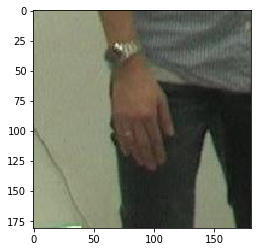

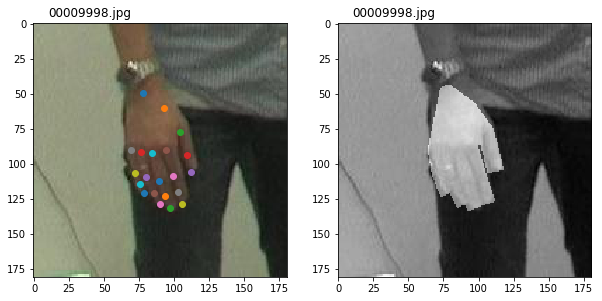

In [23]:
img_dir_root = '/home/deyingk/handpose/data/external/cmu_panoptic_hands/intermediate_1/imgs'
label_dir_root = '/home/deyingk/handpose/data/external/cmu_panoptic_hands/intermediate_1'

with open(os.path.join(label_dir_root,'labels.json'), 'r') as f:
    labels = json.load(f)

image_name = '00009998.jpg'
image_path = os.path.join(img_dir_root, image_name)
img = Image.open(image_path)
label = labels[image_name]

visualize_mask(image_name, img, label)

(181, 181)